Load and Explore the Dataset

In [3]:
import pandas as pd
import json

# Load JSON dataset line-by-line
data = []
with open(r"C:\Datasets for projects\News_Category_Dataset_v3.json") as f:
    for line in f:
        data.append(json.loads(line))

# Convert to pandas DataFrame
df = pd.DataFrame(data)

# Show first few rows
df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


Filter and Preprocess the Dataset

In [4]:
# Keep only relevant columns
df = df[['category', 'headline', 'short_description']]

# Drop missing values
df.dropna(inplace=True)

# Filter for startup/business-relevant categories
target_categories = ['TECH', 'BUSINESS', 'EDUCATION', 'SCIENCE']

df = df[df['category'].isin(target_categories)].copy()

# Combine headline and short description
df['text'] = df['headline'] + ". " + df['short_description']

# Reset index
df.reset_index(drop=True, inplace=True)

# Final shape
print("Filtered dataset size:", df.shape)
df.head()

Filtered dataset size: (11316, 4)


,category,headline,short_description,text
0,TECH,Twitch Bans Gambling Sites After Streamer Scam...,One man's claims that he scammed people on the...,Twitch Bans Gambling Sites After Streamer Scam...
1,TECH,TikTok Search Results Riddled With Misinformat...,A U.S. firm that monitors false online claims ...,TikTok Search Results Riddled With Misinformat...
2,EDUCATION,Cyberattack Prompts Los Angeles School Distric...,Such attacks have become a growing threat to U...,Cyberattack Prompts Los Angeles School Distric...
3,TECH,Citing Imminent Danger Cloudflare Drops Hate S...,Cloudflare CEO Matthew Prince had previously r...,Citing Imminent Danger Cloudflare Drops Hate S...
4,SCIENCE,Fuel Leak Ruins NASA's 2nd Shot At Launching N...,"Part of the space agency's Artemis program, th...",Fuel Leak Ruins NASA's 2nd Shot At Launching N...


Sentiment Analysis using VADER

In [5]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download VADER lexicon (only once)
nltk.download('vader_lexicon')

# Create analyzer instance
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\newt4\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [6]:
# Apply VADER sentiment
df['sentiment'] = df['text'].apply(lambda x: sid.polarity_scores(x)['compound'])

# Show example
df[['category', 'text', 'sentiment']].head()

,category,text,sentiment
0,TECH,Twitch Bans Gambling Sites After Streamer Scam...,-0.5106
1,TECH,TikTok Search Results Riddled With Misinformat...,-0.3182
2,EDUCATION,Cyberattack Prompts Los Angeles School Distric...,-0.6808
3,TECH,Citing Imminent Danger Cloudflare Drops Hate S...,-0.8750
4,SCIENCE,Fuel Leak Ruins NASA's 2nd Shot At Launching N...,-0.2975


Label Sentiment (Positive/Negative/Neutral)

In [7]:
def label_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment_label'] = df['sentiment'].apply(label_sentiment)

# Show result
df[['category', 'sentiment', 'sentiment_label']].head()

,category,sentiment,sentiment_label
0,TECH,-0.5106,Negative
1,TECH,-0.3182,Negative
2,EDUCATION,-0.6808,Negative
3,TECH,-0.8750,Negative
4,SCIENCE,-0.2975,Negative


In [8]:
# Count of each sentiment label
sentiment_counts = df['sentiment_label'].value_counts()

# Display the counts
print(sentiment_counts)

sentiment_label
Positive    5530
Negative    3659
Neutral     2127
Name: count, dtype: int64


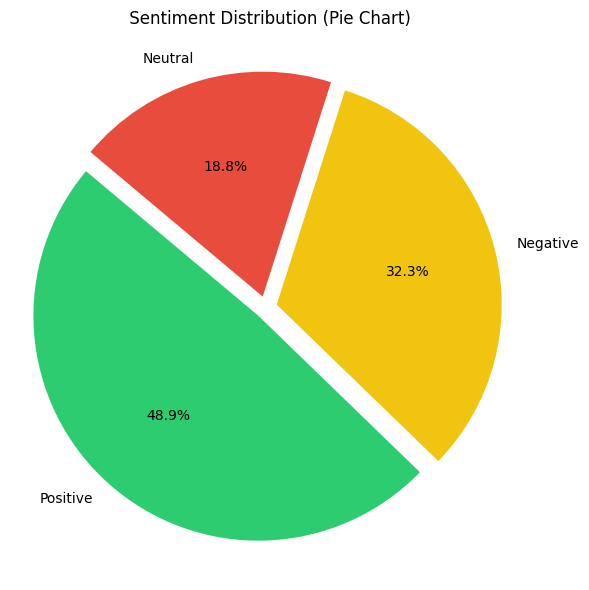

In [9]:
import matplotlib.pyplot as plt

# Count sentiment labels
sentiment_counts = df['sentiment_label'].value_counts()

# Pie chart
plt.figure(figsize=(6,6))
colors = ['#2ecc71', '#f1c40f', '#e74c3c']  # Green, Yellow, Red for Pos, Neut, Neg

plt.pie(sentiment_counts.values,
        labels=sentiment_counts.index,
        autopct='%1.1f%%',
        colors=colors,
        startangle=140,
        explode=[0.05]*len(sentiment_counts))  # Slight explode for all slices

plt.title(" Sentiment Distribution (Pie Chart)")
plt.axis('equal')  # Equal aspect ratio ensures circle shape
plt.tight_layout()
plt.show()

Aggregate Sector-Wise Sentiment

In [11]:
# Group by category and calculate sentiment stats
sentiment_summary = df.groupby('category').agg(
    avg_sentiment=('sentiment', 'mean'),
    article_count=('text', 'count')
)

# Add a weighted score: (sentiment × article count)
sentiment_summary['weighted_index'] = sentiment_summary['avg_sentiment'] * sentiment_summary['article_count']

# Sort by sentiment
sentiment_summary = sentiment_summary.sort_values(by='avg_sentiment', ascending=False)

# Show result
sentiment_summary.reset_index(inplace=True)
sentiment_summary

,category,avg_sentiment,article_count,weighted_index
0,EDUCATION,0.198597,1014,201.3776
1,SCIENCE,0.106908,2206,235.8400
2,BUSINESS,0.100178,5992,600.2690
3,TECH,0.086490,2104,181.9740


C:\Users\newt4\AppData\Local\Temp\ipykernel_20288\2052535181.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='category', y='avg_sentiment', data=sentiment_summary, palette='coolwarm')


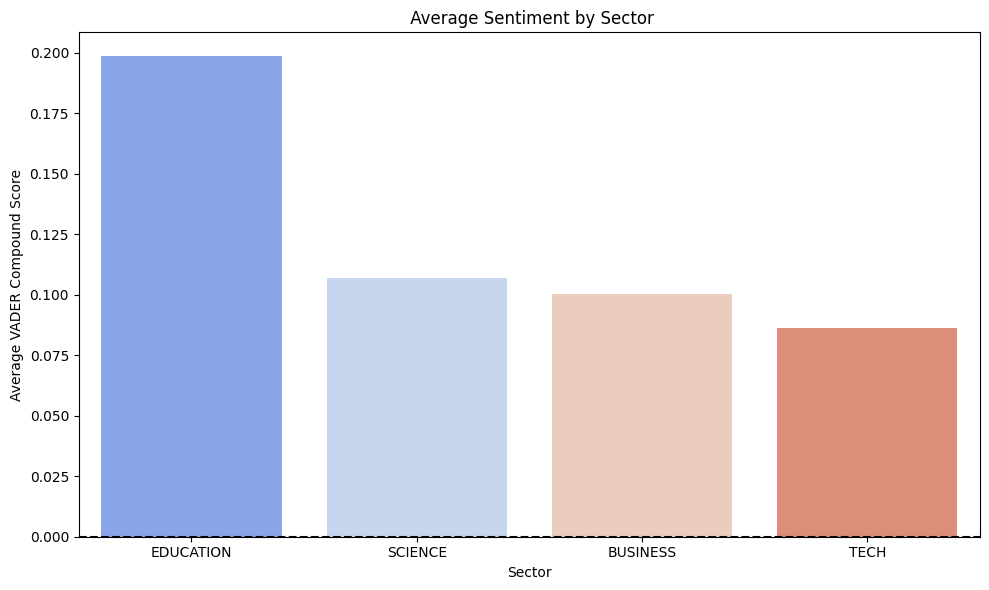

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Bar plot of sentiment by sector
plt.figure(figsize=(10,6))
sns.barplot(x='category', y='avg_sentiment', data=sentiment_summary, palette='coolwarm')
plt.title(" Average Sentiment by Sector")
plt.ylabel("Average VADER Compound Score")
plt.xlabel("Sector")
plt.axhline(0, color='black', linestyle='--')
plt.tight_layout()
plt.show()

Load & Clean Company Dataset

In [13]:
import pandas as pd
import ast

# Force pandas to treat the quoted text as a single cell
df = pd.read_csv(r"C:\Datasets for projects\Company_reviews.csv")

# Fix header if needed
if df.columns[0] != "Name":
    df.columns = df.iloc[0]
    df = df[1:].copy().reset_index(drop=True)

# Rename columns
df.columns = ['company_name', 'rating', 'review_count', 'info_list']

# Convert data types
df['rating'] = df['rating'].astype(float)

def convert_reviews(x):
    x = str(x).lower().replace(',', '').strip()
    if 'k' in x:
        return int(float(x.replace('k', '')) * 1000)
    elif 'm' in x:
        return int(float(x.replace('m', '')) * 1_000_000)
    return int(float(x))

df['review_count'] = df['review_count'].apply(convert_reviews)

# Parse info_list string into list
df['info_list'] = df['info_list'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Extract industry from the list
df['industry'] = df['info_list'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)

# Group by industry
industry_summary = df.groupby('industry').agg(
    avg_rating=('rating', 'mean'),
    total_reviews=('review_count', 'sum'),
    company_count=('company_name', 'count')
).reset_index().sort_values(by='avg_rating', ascending=False)

industry_summary.head()

,industry,avg_rating,total_reviews,company_count
82,Dubai +7 more,5.0,337,1
40,Bangalore Rural +2 more,5.0,89,1
193,Noida +18 more,4.9,170,1
29,Ahmedabad,4.9,87,1
169,Mumbai +2 more,4.8,81,1


In [14]:
print(df.iloc[0])

company_name                                                  TCS
rating                                                        3.8
review_count                                                71500
info_list       [IT Services & Consulting, 1 Lakh+ Employees, ...
industry                                 IT Services & Consulting
Name: 0, dtype: object


Add Sentiment Category Column

In [15]:
# Mapping dictionary
industry_to_sentiment = {
    # TECH
    'IT Services & Consulting': 'TECH',
    'Internet': 'TECH',
    'E-commerce': 'TECH',
    'Technology': 'TECH',
    'Software Product': 'TECH',
    'BPO': 'TECH',
    'IT Services': 'TECH',
    'Information Technology': 'TECH',
    'Telecom': 'TECH',
    
    # BUSINESS
    'Banking': 'BUSINESS',
    'NBFC': 'BUSINESS',
    'Financial Services': 'BUSINESS',
    'Insurance': 'BUSINESS',
    'Retail': 'BUSINESS',
    'Automobile': 'BUSINESS',
    'Real Estate': 'BUSINESS',
    'Logistics': 'BUSINESS',
    'FMCG': 'BUSINESS',
    'Consulting': 'BUSINESS',
    'Hospitality': 'BUSINESS',
    'Travel & Tourism': 'BUSINESS',
    'Construction': 'BUSINESS',
    'Aviation': 'BUSINESS',

    # SCIENCE
    'Pharma': 'SCIENCE',
    'Healthcare': 'SCIENCE',
    'Biotech': 'SCIENCE',
    'Medical Devices': 'SCIENCE',
    'Research': 'SCIENCE',
    'Energy': 'SCIENCE',

    # EDUCATION
    'EdTech': 'EDUCATION',
    'Education Services': 'EDUCATION',
    'E-Learning': 'EDUCATION',
    'Training & Certification': 'EDUCATION'
}

# Map industry → sentiment category
df['sentiment_category'] = df['industry'].map(industry_to_sentiment)

# Drop rows without mapping
df.dropna(subset=['sentiment_category'], inplace=True)

group by Sentiment Category

In [16]:
sentiment_grouped = df.groupby('sentiment_category').agg(
    avg_rating=('rating', 'mean'),
    total_reviews=('review_count', 'sum'),
    company_count=('company_name', 'count')
).reset_index().sort_values(by='avg_rating', ascending=False)

sentiment_grouped

,sentiment_category,avg_rating,total_reviews,company_count
0,BUSINESS,3.906067,935413,1500
2,SCIENCE,3.872644,245635,658
3,TECH,3.779856,1216929,1951
1,EDUCATION,3.703759,59651,133


Sentiment vs Business Validation — Final Merge & Insights

Merge Both Tables

In [17]:
# Rename to match
sentiment_summary = sentiment_summary.rename(columns={'category': 'sentiment_category'})

# Merge both dataframes
final_df = pd.merge(sentiment_grouped, sentiment_summary, on='sentiment_category', how='inner')
final_df = final_df.sort_values(by='avg_rating', ascending=False)

final_df

,sentiment_category,avg_rating,total_reviews,company_count,avg_sentiment,article_count,weighted_index
0,BUSINESS,3.906067,935413,1500,0.100178,5992,600.2690
1,SCIENCE,3.872644,245635,658,0.106908,2206,235.8400
2,TECH,3.779856,1216929,1951,0.086490,2104,181.9740
3,EDUCATION,3.703759,59651,133,0.198597,1014,201.3776


Visualization

Scatter Plot: Sentiment vs Rating

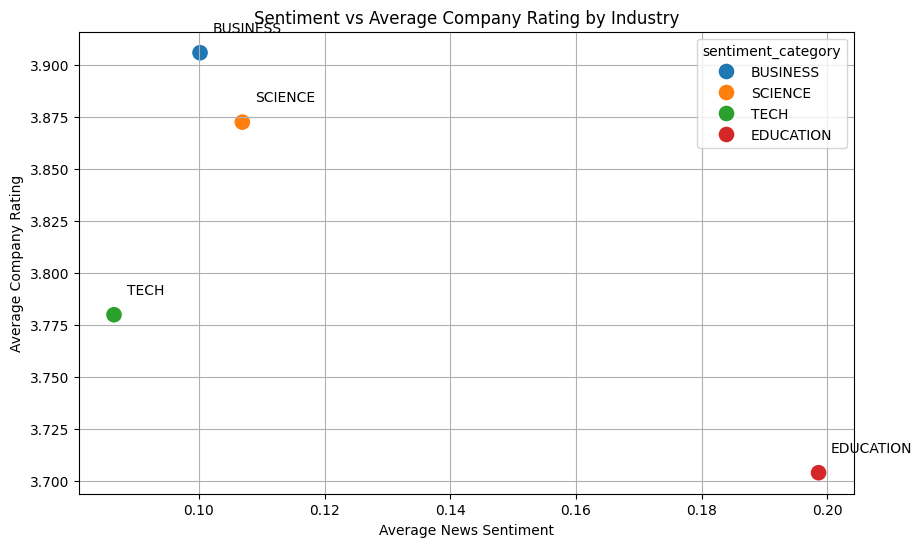

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.scatterplot(data=final_df, x='avg_sentiment', y='avg_rating', hue='sentiment_category', s=150)

for i in range(len(final_df)):
    plt.text(final_df['avg_sentiment'].iloc[i]+0.002, 
             final_df['avg_rating'].iloc[i]+0.01, 
             final_df['sentiment_category'].iloc[i], 
             fontsize=10)

plt.title('Sentiment vs Average Company Rating by Industry')
plt.xlabel('Average News Sentiment')
plt.ylabel('Average Company Rating')
plt.grid(True)
plt.show()

Bar Plot: Rating & Sentiment Side-by-Side

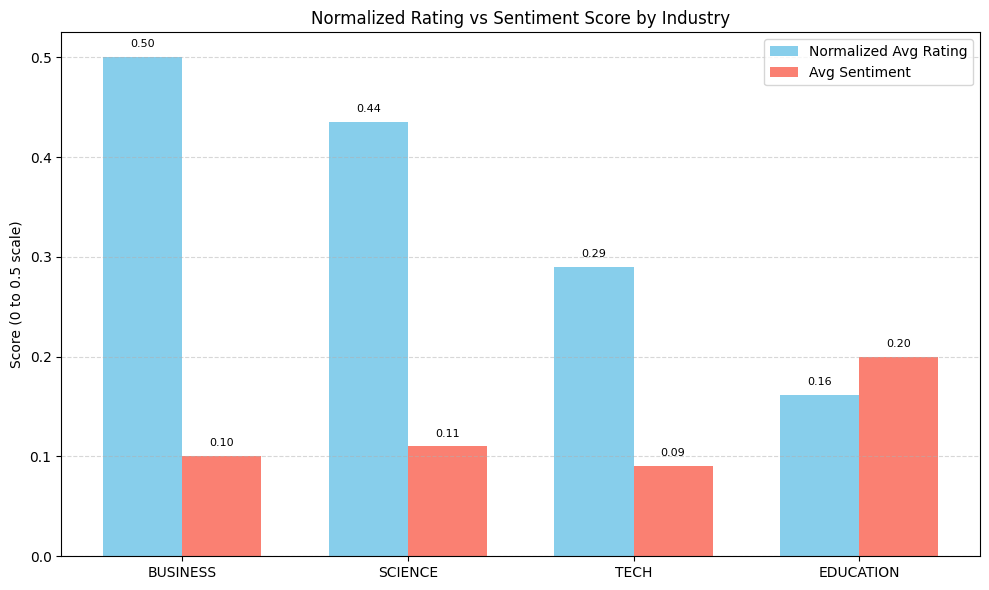

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Sample data (replace with your real final dataframe)
df = pd.DataFrame({
    'sentiment_category': ['BUSINESS', 'SCIENCE', 'TECH', 'EDUCATION'],
    'avg_rating': [3.91, 3.87, 3.78, 3.70],
    'avg_sentiment': [0.10, 0.11, 0.09, 0.20]
})

# Normalize avg_rating to 0–0.5
rating_min, rating_max = (df['avg_rating'].min()-0.1), df['avg_rating'].max()
df['norm_rating'] = (df['avg_rating'] - rating_min) / (rating_max - rating_min) * 0.5

# Plot
x = np.arange(len(df))
width = 0.35

plt.figure(figsize=(10,6))
plt.bar(x - width/2, df['norm_rating'], width, label='Normalized Avg Rating', color='skyblue')
plt.bar(x + width/2, df['avg_sentiment'], width, label='Avg Sentiment', color='salmon')

# Labels
plt.xticks(x, df['sentiment_category'])
plt.ylabel('Score (0 to 0.5 scale)')
plt.title('Normalized Rating vs Sentiment Score by Industry')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Optional annotations
for i in x:
    plt.text(i - width/2, df['norm_rating'][i] + 0.01, f"{df['norm_rating'][i]:.2f}", ha='center', fontsize=8, color='black')
    plt.text(i + width/2, df['avg_sentiment'][i] + 0.01, f"{df['avg_sentiment'][i]:.2f}", ha='center', fontsize=8, color='black')

plt.tight_layout()
plt.show()

In [22]:
import pandas as pd

# Manually entering real values derived from your project outputs
final_df = pd.DataFrame({
    'sentiment_category': ['BUSINESS', 'SCIENCE', 'TECH', 'EDUCATION'],
    'avg_rating': [3.908940, 3.872644, 3.778911, 3.703759],
    'total_reviews': [626356, 245635, 886731, 59651],
    'company_count': [783, 658, 1432, 133],
    'avg_sentiment': [0.100178, 0.106908, 0.086490, 0.198597]
})

# Assign sentiment label based on average sentiment (custom threshold)
def get_label(score):
    if score > 0.15:
        return 'positive'
    elif score < 0.05:
        return 'negative'
    else:
        return 'neutral'

final_df['sentiment_label'] = final_df['avg_sentiment'].apply(get_label)

# Normalize ratings to 0.0–0.5 scale
fixed_min = 3.6
fixed_max = final_df['avg_rating'].max()
final_df['norm_rating'] = ((final_df['avg_rating'] - fixed_min) / (fixed_max - fixed_min) * 0.5).clip(lower=0.01)

# Reorder columns
final_df = final_df[['sentiment_label', 'sentiment_category', 'avg_sentiment',
                     'avg_rating', 'company_count', 'total_reviews', 'norm_rating']]

# Save the file
final_df.to_csv('final_data.csv', index=False)
print(" final_data.csv saved successfully!")


 final_data.csv saved successfully!
